# Pipeline for running inference and classifying squat reps

In [1]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
from sklearn import tree

sys.path.append('../data')
sys.path.append('..')
sys.path.append('../inference')
sys.path.append('../feedback')

import testing_utils as tu
from ai_trainer import Personal_Trainer

%matplotlib inline

# Step 1: Instantiate our personal trainer and load preprocessed data

In [6]:
pt = Personal_Trainer({'squat':'NeckY'})
exercise = 'squat'

#=====[ Rehydrate dataset for training ]=====
pt.load_reps(exercise, os.path.join('../data/data_sets','multipleClass4.p'))

# Step 2: Extract features 

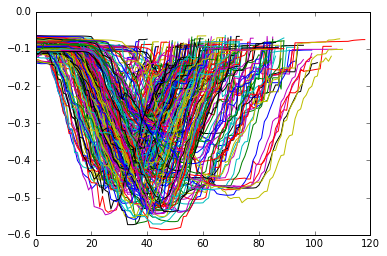

In [7]:
plt.clf()
for squat in pt.get_reps(exercise):
    plt.plot(-squat['NeckY'])

# Step 3: Forward Search

In [8]:
def forward_search(num_features, X, Y, file_names, clf_class, **kwargs):
    
    #=====[ Keeps track of best global accuracy and fscore ]======
    best_accuracy = 0
    best_fscore = 0 
    
    #=====[ Builds new feature vector and returns indices of best features to use ]=====
    X_new = X[:,0:0]
    indices = []
        
    for feature in range(num_features):

        #=====[ Used to make sure we have not found a maximum in our accuracy/fscore ]======
        feature_added = False
        
        #=====[ Loops through every feature in X to find the next best feature ]=====
        for index in range(X.shape[1]):
                
            X_temp = np.concatenate([X_new,X[:,index:(index+1)]],axis=1)
            
            fscore, accuracy = tu.rnd_prediction(X_temp,Y,file_names,clf_class,**kwargs)

            #=====[ Checks mean square error between accuracy and f_score ]=====
            if ((1-accuracy)**2 + (1-fscore)**2) < ((1-best_accuracy)**2 + (1-best_fscore)**2):
                best_accuracy = accuracy
                best_fscore = fscore
                best_index = index
                feature_added = True

        if feature_added:
            indices.append(best_index)
            X_new = np.concatenate([X_new,X[:,best_index:(best_index+1)]],axis=1)
        else:
            break
    
    #=====[ Print stats and return indices of top features ]=====
    print "Best accuracy:", best_accuracy
    print "Best f-score:", best_fscore
    return indices           

# Step 3: Classification

## Best performing classifiers for 5 squat components

In [9]:
#=====[ Best classifier for bending hips and knees at the same time ]=====

#=====[ The multiples argument is indicative of how many frames we take between a squatter's start and bottom state and their bottom and end state]=====
X3, Y3, file_names = pt.extract_advanced_features(multiples=[float(x)/20 for x in range(1,20)])
X30 = np.concatenate([X3[x] for x in X3], axis=1)

print '\n\nDecision Tree with max depth 3 and entropy\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X3['bend_hips_knees'], Y3['bend_hips_knees'], file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
indices = forward_search(10,X30, Y3['bend_hips_knees'], file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
print indices


math domain error


Decision Tree with max depth 3 and entropy


Fscore: 0.576923, Accuracy: 0.903337
Best accuracy: 0.968151861134
Best f-score: 0.818181818182
[193, 199, 270]


In [30]:
#=====[ Best classifier for squat stance ]=====

#=====[ The multiples argument is indicative of how many frames we take between a squatter's start and bottom state and their bottom and end state]=====
X15, Y15, file_names = pt.extract_advanced_features(multiples=[0.2, 0.4, 0.6, 0.8])

print '\n\nLogistic Regression with L1\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X15['stance_width'], Y15['stance_width'], file_names, linear_model.LogisticRegression, penalty='l1')
indices = forward_search(10, X30, Y3['stance_width'], file_names, linear_model.LogisticRegression, penalty='l1')
print indices

math domain error


Logistic Regression with L1


Fscore: 0.772727, Accuracy: 0.897046
Best accuracy: 0.979012345679
Best f-score: 0.933333333333
[55, 16, 86, 54]


In [31]:
#=====[ Best classifier for squat depth ]=====

#=====[ The multiples argument is indicative of how many frames we take between a squatter's start and bottom state and their bottom and end state]=====
X0, Y0, file_names = pt.extract_advanced_features(multiples=[0.5])

print '\n\nLogistic Regression with L1\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X0['squat_depth'], Y0['squat_depth'], file_names, linear_model.LogisticRegression, penalty='l1', C=0.05)
indices = forward_search(10, X30, Y0['squat_depth'], file_names, linear_model.LogisticRegression, penalty='l1', C=0.05)
print indices



Logistic Regression with L1


Fscore: 0.830769, Accuracy: 0.824315
Best accuracy: 0.841598524932
Best f-score: 0.845360824742
[399, 322]


In [32]:
#=====[ Best classifier for checking if knees over toes ]=====
y = tu.coalesce_twos(Y3['knees_over_toes'])

print '\n\nDecision Tree with max depth 3 and entropy\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X30, y, file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
indices = forward_search(10, X30, y, file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
print indices



Decision Tree with max depth 3 and entropy


Fscore: 0.879479, Accuracy: 0.828029
Best accuracy: 0.855870315519
Best f-score: 0.907348242812
[416, 250, 362]


In [34]:
#=====[ Best classifier for checking the back-hip angle ]=====

#=====[ The multiples argument is indicative of how many frames we take between a squatter's start and bottom state and their bottom and end state]=====
X0, Y00, file_names = pt.extract_advanced_features(multiples=[0.5])
X00 = np.concatenate([X0[x] for x in X0],axis=1)

print "\n\nLogistic Regression\n\n"
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X00, Y00['back_hip_angle'], file_names, linear_model.LogisticRegression, penalty = 'l1', C=2.5)
indices = forward_search(20, X30, Y00['back_hip_angle'],file_names, linear_model.LogisticRegression, penalty = 'l1', C=2.5)
print indices



Logistic Regression


Fscore: 0.724324, Accuracy: 0.757961
Best accuracy: 0.855379188713
Best f-score: 0.869565217391
[305, 41, 409, 79, 153, 292, 363, 85, 324, 275]


In [50]:
#=====[ Aggregate feature indices and store ]=====
feature_indices = {'back_hip_angle':[305, 41, 409, 79, 153, 292, 363, 85, 324, 275], 'knees_over_toes':[416, 250, 362], 'squat_depth':[399, 322], 'stance_width':[55, 16, 86, 54], 'bend_hips_knees':[193, 199, 270] }
pickle.dump(feature_indices,open('squat_feature_indicies.p','wb'))

# Step 4: Plot Accuracy and F-Score vs. Num Training Examples

In [10]:
#=====[ Plot accuracy and F-score for knees over toes averaged over 20 iteration ]======
f_score = []
f_score_t = []
accuracy = []
accuracy_t = []

num_iters = 20

#=====[ Using full feature set and y labels for knees_over_toes ]=====
for _ in range(0,num_iters):
    f, ft, a, at = tu.rnd_prediction_increase_training(X30, y, file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
    f_score.append(f)
    f_score_t.append(ft)
    accuracy.append(a)
    accuracy_t.append(at)

In [13]:
#=====[ Average each of num_iter runs ]=====
f = [np.average(l) for l in zip(*list(f_score))]
ft = [np.average(l) for l in zip(*list(f_score_t))]
a = [np.average(l) for l in zip(*list(accuracy))]
at = [np.average(l) for l in zip(*list(accuracy_t))]

[0, 200, 0, 1.0]

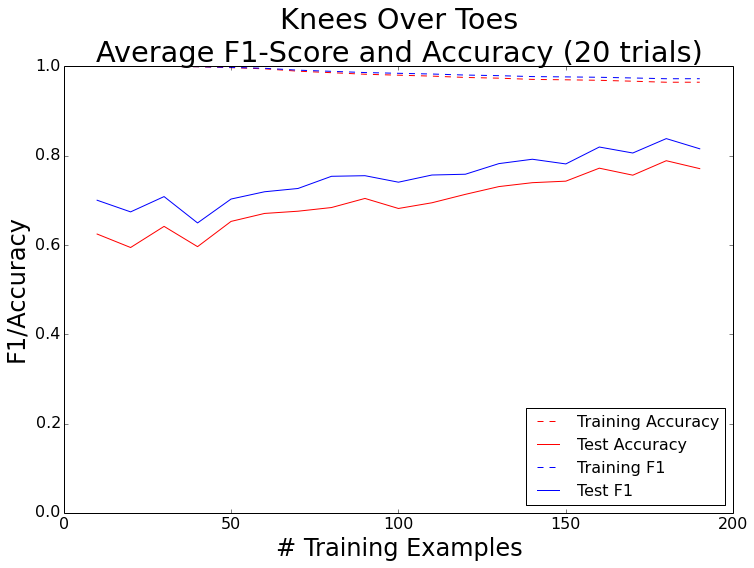

In [14]:
num_training_examples = [x*10 for x in range(1,20)]

#=====[ Plot test and training f_scores and accuracies ]====
plt.plot(num_training_examples, at, color='r', linestyle='--', label='Training Accuracy')
plt.plot(num_training_examples, a, color='r', label='Test Accuracy')
plt.plot(num_training_examples, ft, color='b', linestyle='--', label='Training F1')
plt.plot(num_training_examples, f, color='b', label='Test F1')

#=====[ Add appropriate plot decorations - preparing for saving ]=====
plt.legend(loc='lower right', prop={'size':16})
plt.title('Knees Over Toes \nAverage F1-Score and Accuracy (20 trials)')
plt.xlabel('# Training Examples')
plt.ylabel('F1/Accuracy')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axis([0, 200, 0, 1.0])
